In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last" # all | last | last_expr | none 

In [3]:
# for name in dir():
#     if not name.startswith('_'):
#         del globals()[name]

In [4]:
# ============= Import required packaages ==============
import time

# Import all custom variables and modules
from custom_classes_defs.preprocessing import *
# from custom_classes_defs.unet0 import * 
# from custom_classes_defs.Unet_like import *  
from custom_classes_defs.unet import *  
# from custom_classes_defs.fnet0 import *
# from custom_classes_defs.fnet_like import *
# from custom_classes_defs.fnet import *

RND_STATE = 247
BATCH_SIZE = 256
keras.utils.set_random_seed(RND_STATE)
from keras.utils import plot_model

INTERACTIVE_SESSION = True

# -------------------------------------------------------

2024-05-26 16:49:24.717389: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-26 16:49:24.717465: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-26 16:49:24.802098: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-26 16:49:24.920294: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
# Verify tensorflow/keras versions
print(f"tensorflow version: {tf.__version__}")
print(f"keras version: {keras.__version__}")

# Verify CPU/GPU availability
print(tf.config.list_physical_devices())
NUM_GPU = len(tf.config.list_physical_devices('GPU'))
print(f"Number of GPUs assigned for computation: {NUM_GPU}")

if NUM_GPU:
    # print GPU info
    !nvidia-smi

tensorflow version: 2.15.0
keras version: 2.15.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Number of GPUs assigned for computation: 1
/usr/local/bin/bash: /opt/miniconda3-py311/lib/libtinfo.so.6: no version information available (required by /usr/local/bin/bash)


Sun May 26 16:49:56 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.29.06              Driver Version: 545.29.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|


|   0  NVIDIA A100 80GB PCIe          Off | 00000000:01:00.0 Off |                    0 |
| N/A   51C    P0             292W / 300W |  57829MiB / 81920MiB |    100%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80GB PCIe          Off | 00000000:41:00.0 Off |                    0 |
| N/A   29C    P0              42W / 300W |      7MiB / 81920MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+----------------------+
|   2  NVIDIA A100 80GB PCIe          Off | 00000000:61:00.0 Off |                    0 |
| N/A   28C    P0              43W / 300W |      4MiB / 81920MiB |      0%      Default |
|                                         |                      |             Disabled |
+---------

|   4  NVIDIA A100 80GB PCIe          Off | 00000000:C1:00.0 Off |                    0 |
| N/A   27C    P0              42W / 300W |      7MiB / 81920MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+----------------------+
|   5  NVIDIA A100 80GB PCIe          Off | 00000000:E1:00.0 Off |                    0 |
| N/A   27C    P0              41W / 300W |      4MiB / 81920MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+----------------------+
                                                                                         
+---------------------------------------------------------------------------------------+
| Processes:                                                                            |
|  GPU   G

### Data preparation and model configurations

In [6]:
print("{}\n\t{}\n{}".format('='*55,'Data preparation and model configurations', '-'*55))
# Images and annations for Thebe seismic data
start = time.time()
img_url = '../thebe_new/seismic'
target_url = '../thebe_new/fault'
seis = Thebe(img_url, target_url)
    
# Create datasets for respective data samples and labels
train_dataset = seis.data_generator('train', batch_size=BATCH_SIZE, cache=NUM_GPU) 
val_dataset = seis.data_generator('val', batch_size=BATCH_SIZE, cache=NUM_GPU)
x_test, y_test = seis.data_generator('test', as_numpy=True)
        
print("Train Dataset:", train_dataset)

print("Size of training data: {}".format(seis.train_size))
print("Size of validation data: {}".format(seis.validation_size))
print("Size of test data: {}".format(seis.test_size)) 

print('...elapsed time: ___{:5.2f} minutes___'.format((time.time()-start) / 60))

	Data preparation and model configurations
-------------------------------------------------------


2024-05-26 16:50:19.084461: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79086 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:c1:00.0, compute capability: 8.0


Train Dataset: <CacheDataset element_spec=(TensorSpec(shape=(None, 96, 96, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 96, 96, 1), dtype=tf.float32, name=None))>
Size of training data: 181029
Size of validation data: 64317
Size of test data: 66077
...elapsed time: ___ 0.93 minutes___


2024-05-26 16:51:09.419003: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


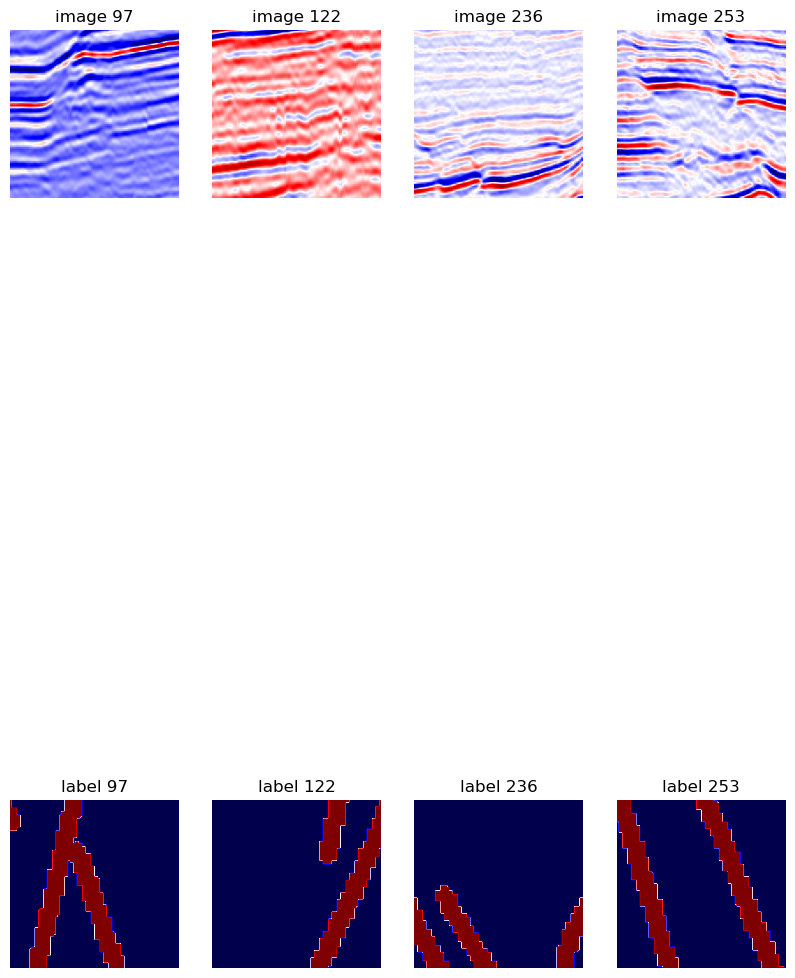

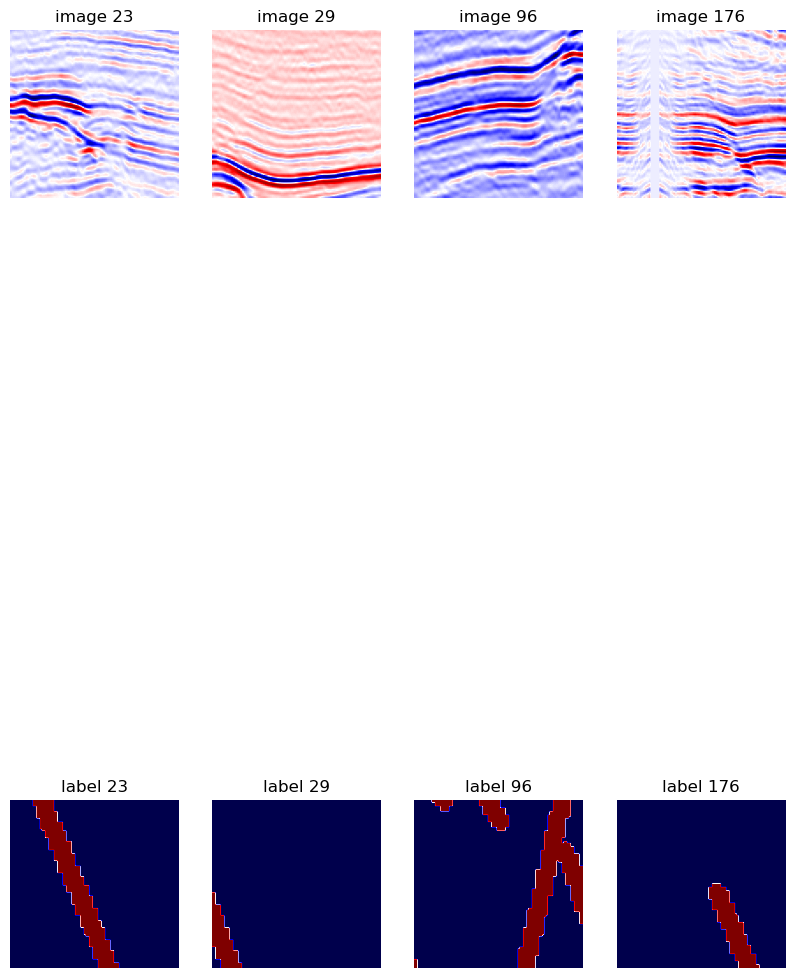

In [7]:
if INTERACTIVE_SESSION:
    X, y = next(train_dataset.as_numpy_iterator())
    # X, y = next(val_dataset.as_numpy_iterator())
    seis.display_sample_images(X, y, num_images=4)
    seis.display_sample_images(X, y, num_images=4)

    # seis.display_sample_images(x_test, y_test, num_images=4)
    # seis.display_sample_images(x_test, y_test, num_images=4)


In [8]:
# Model configurations
conf = model_config(
    epochs=100,
    batch_size=BATCH_SIZE,
    shuffle=True,
    scaling=1,
    save_path='./Thebe/unet',
    img_shape=seis.img_size,
    target_size=seis.img_size,
    threshold=seis.threshold,
    pos_label=seis.pos_label,
    train_size=seis.train_size,
    test_size=seis.test_size,
    new_training_session=True,
    multiple_gpu_device=(NUM_GPU>1),
    validation_size=seis.validation_size
)

callbacks = conf.callbacks(
    chkpt_monitor='val_f1_score', 
    es_monitor='val_loss',
    es_patience=100, 
    lr_monitor='val_loss',
)

conf.set( validation_data=val_dataset,  callbacks=callbacks )
m1 = f1_score(positive_label=seis.pos_label, threshold=seis.threshold)
conf.set(
    'compile',
    metrics= ['accuracy', m1]
)

# conf.double_check(INTERACTIVE_SESSION)
conf.info()

             NUM_GPU: 1
        compile_args:
                     optimizer: adam
                          loss: binary_crossentropy
                       metrics: accuracy
                              : f1_score(name=f1_score,dtype=float32)
              labels: ListWrapper([0, 1])
     mixed_precision: None
          model_arch:
                     img_shape: (96, 96)
                   target_size: (96, 96)
                  channels_dim: (1, 1)
                       scaling: 1
                  augmentation: False
 multiple_gpu_device: False
new_training_session: True
           pos_label: 1
           save_path: ./Thebe/unet
           test_size: 66077
           threshold: 0.5
          train_size: 181029
       training_args:
                        epochs: 100
                    batch_size: 256
                       shuffle: True
                       verbose: 0
               validation_data: <class 'tensorflow.python.data.ops.cache_op.CacheDataset'>
                 

### Build  model 

In [9]:
print("\n\n{}\n\t{}\n{}".format('='*55,f'Build model', '-'*55))

if conf.multiple_gpu_device:

    strategy = tf.distribute.MirroredStrategy()
    print(f"Number of devices: {strategy.num_replicas_in_sync}")
    with strategy.scope():

        conf = model_config(
            epochs=100,
            batch_size=BATCH_SIZE,
            shuffle=True,
            scaling=1,
            save_path='./Thebe/unet',
            img_shape=seis.img_size,
            target_size=seis.img_size,
            threshold=seis.threshold,
            pos_label=seis.pos_label,
            train_size=seis.train_size,
            test_size=seis.test_size,
            new_training_session=True,
            multiple_gpu_device=(NUM_GPU>1),
            validation_size=seis.validation_size
        )

        callbacks = conf.callbacks(
            chkpt_monitor='val_f1_score', 
            es_monitor='val_loss',
            es_patience=100, 
            lr_monitor='val_loss'
        )

        conf.set( validation_data=val_dataset,  callbacks=callbacks )
        m1 = f1_score(positive_label=seis.pos_label, threshold=seis.threshold)
        conf.set(
            'compile',
            metrics= ['accuracy', m1]
        )

        m_obj = UNET2D(panel_sizes=[32,64,128,256], model_arch=conf.model_arch)
        # m_obj = FNET2D(panel_sizes=[32,64,128,256], model_arch=conf.model_arch)
        model = m_obj.build_model()
        model.compile(**conf.compile_args)

else:

    m_obj = UNET2D(panel_sizes=[32,64,128,256], model_arch=conf.model_arch)
    # m_obj = FNET2D(panel_sizes=[32,64,128,256], model_arch=conf.model_arch)
    model = m_obj.build_model()
    model.compile(**conf.compile_args)


# model.summary()
# keras.utils.plot_model(model, 'm_obj.png',show_shapes=True)
# plot_model(model, 'm_obj.png',show_shapes=True)
num_trainable_weights = sum([np.prod(w.shape) for w in model.trainable_weights])
print(f"Total number of parameters: {model.count_params():,}")
print(f"Total trainable wieghts: {num_trainable_weights:,}")
print(f"Total non-trainable wieghts: {model.count_params()-num_trainable_weights:,}")





	Build model
-------------------------------------------------------


Total number of parameters: 1,845,409
Total trainable wieghts: 1,842,593
Total non-trainable wieghts: 2,816


### Train  model



	Train unet model
-------------------------------------------------------
Model training...


2024-05-26 16:51:27.956880: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inU-NET/sequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2024-05-26 16:51:28.634218: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907


2024-05-26 16:51:36.508248: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fc8643fc710 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-26 16:51:36.508301: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2024-05-26 16:51:36.551524: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


I0000 00:00:1716735096.826002 3685992 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.



Epoch 22: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.



Epoch 32: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.



Epoch 42: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.



Epoch 52: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.



Epoch 64: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.



Epoch 81: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.



Epoch 91: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.


training elapsed time: ___140.10___ minutes
...training completed!


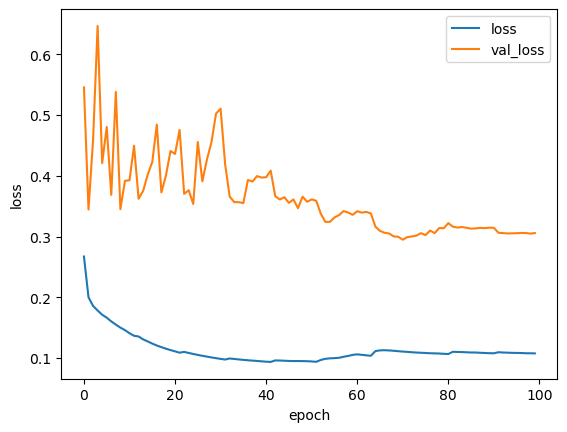

In [10]:
print("\n\n{}\n\t{}\n{}".format('='*55,f'Train {m_obj.Name} model', '-'*55))

model, train_history = \
    conf.execute_training(
        model, 
        data=train_dataset, 
        plot_history=INTERACTIVE_SESSION
)


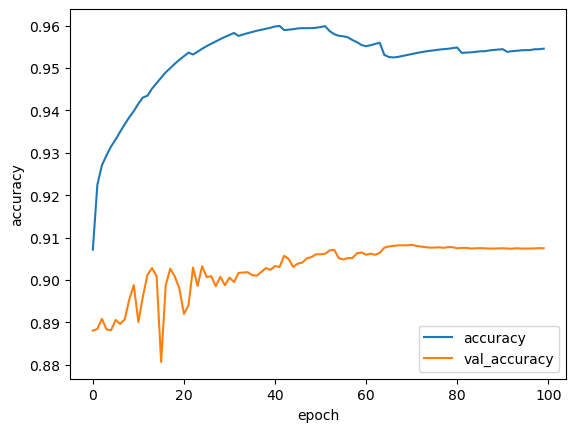

In [11]:
if INTERACTIVE_SESSION:
    show_convergence(train_history.history, ['accuracy','val_accuracy'])

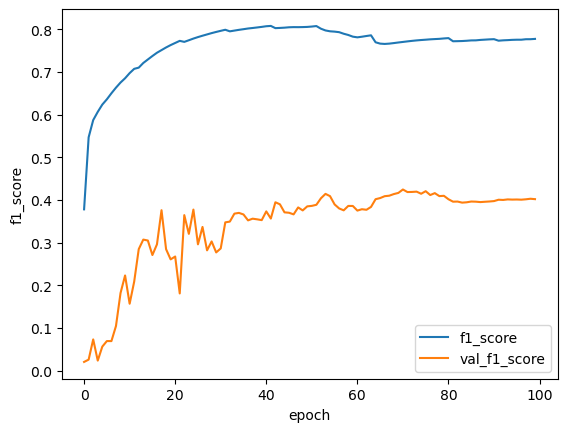

In [12]:
if INTERACTIVE_SESSION:
    show_convergence(train_history.history, ['f1_score','val_f1_score'])

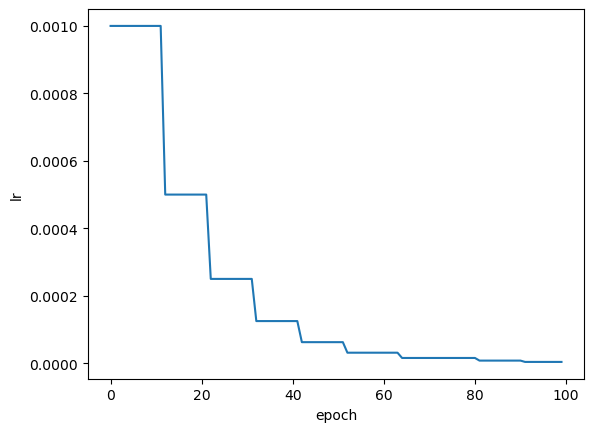

In [13]:
if INTERACTIVE_SESSION:
    show_convergence(train_history.history, 'lr')

### Evaluate and Vizualize

In [14]:
print("\n\n{}\n\t{}\n{}".format('='*55,f'Evaluate {m_obj.Name} model', '-'*55))
y_pred = model.predict(x_test)




	Evaluate unet model
-------------------------------------------------------


   1/2065 [..............................] - ETA: 33:25

  12/2065 [..............................] - ETA: 9s   

  23/2065 [..............................] - ETA: 9s

  34/2065 [..............................] - ETA: 9s

  45/2065 [..............................] - ETA: 9s

  56/2065 [..............................] - ETA: 9s

  67/2065 [..............................] - ETA: 9s

  78/2065 [>.............................] - ETA: 9s

  89/2065 [>.............................] - ETA: 9s

 100/2065 [>.............................] - ETA: 9s

 111/2065 [>.............................] - ETA: 9s

 122/2065 [>.............................] - ETA: 9s

 133/2065 [>.............................] - ETA: 9s

 144/2065 [=>............................] - ETA: 8s

 155/2065 [=>............................] - ETA: 8s

 166/2065 [=>............................] - ETA: 8s

 177/2065 [=>............................] - ETA: 8s

 188/2065 [=>............................] - ETA: 8s

 199/2065 [=>............................] - ETA: 8s

 210/2065 [==>...........................] - ETA: 8s

 221/2065 [==>...........................] - ETA: 8s

 232/2065 [==>...........................] - ETA: 8s

 243/2065 [==>...........................] - ETA: 8s

 254/2065 [==>...........................] - ETA: 8s

 265/2065 [==>...........................] - ETA: 8s

 276/2065 [===>..........................] - ETA: 8s

 287/2065 [===>..........................] - ETA: 8s

 298/2065 [===>..........................] - ETA: 8s

 309/2065 [===>..........................] - ETA: 8s

 320/2065 [===>..........................] - ETA: 8s

 331/2065 [===>..........................] - ETA: 8s

 342/2065 [===>..........................] - ETA: 8s

 353/2065 [====>.........................] - ETA: 7s

 364/2065 [====>.........................] - ETA: 7s

 375/2065 [====>.........................] - ETA: 7s

 386/2065 [====>.........................] - ETA: 7s

 397/2065 [====>.........................] - ETA: 7s

 408/2065 [====>.........................] - ETA: 7s

 419/2065 [=====>........................] - ETA: 7s

 430/2065 [=====>........................] - ETA: 7s

 441/2065 [=====>........................] - ETA: 7s

 452/2065 [=====>........................] - ETA: 7s

 463/2065 [=====>........................] - ETA: 7s

 474/2065 [=====>........................] - ETA: 7s

 485/2065 [======>.......................] - ETA: 7s

 496/2065 [======>.......................] - ETA: 7s

 507/2065 [======>.......................] - ETA: 7s

 518/2065 [======>.......................] - ETA: 7s

 529/2065 [======>.......................] - ETA: 7s

 540/2065 [======>.......................] - ETA: 7s

 551/2065 [=======>......................] - ETA: 7s

 562/2065 [=======>......................] - ETA: 7s

 573/2065 [=======>......................] - ETA: 6s

 584/2065 [=======>......................] - ETA: 6s

 595/2065 [=======>......................] - ETA: 6s

 606/2065 [=======>......................] - ETA: 6s

 617/2065 [=======>......................] - ETA: 6s

 628/2065 [========>.....................] - ETA: 6s

 639/2065 [========>.....................] - ETA: 6s

 650/2065 [========>.....................] - ETA: 6s

 661/2065 [========>.....................] - ETA: 6s

 672/2065 [========>.....................] - ETA: 6s

 683/2065 [========>.....................] - ETA: 6s

 694/2065 [=========>....................] - ETA: 6s

 705/2065 [=========>....................] - ETA: 6s

 716/2065 [=========>....................] - ETA: 6s

 727/2065 [=========>....................] - ETA: 6s

 738/2065 [=========>....................] - ETA: 6s

 749/2065 [=========>....................] - ETA: 6s

 760/2065 [==========>...................] - ETA: 6s

 771/2065 [==========>...................] - ETA: 6s

 782/2065 [==========>...................] - ETA: 5s

 793/2065 [==========>...................] - ETA: 5s

 804/2065 [==========>...................] - ETA: 5s

 815/2065 [==========>...................] - ETA: 5s

 826/2065 [===========>..................] - ETA: 5s

 837/2065 [===========>..................] - ETA: 5s

 848/2065 [===========>..................] - ETA: 5s

 859/2065 [===========>..................] - ETA: 5s

 870/2065 [===========>..................] - ETA: 5s

 881/2065 [===========>..................] - ETA: 5s

 892/2065 [===========>..................] - ETA: 5s

 903/2065 [============>.................] - ETA: 5s

 914/2065 [============>.................] - ETA: 5s

 925/2065 [============>.................] - ETA: 5s

 936/2065 [============>.................] - ETA: 5s

 947/2065 [============>.................] - ETA: 5s

 958/2065 [============>.................] - ETA: 5s

 969/2065 [=============>................] - ETA: 5s

 980/2065 [=============>................] - ETA: 5s

 991/2065 [=============>................] - ETA: 5s

1002/2065 [=============>................] - ETA: 4s

1013/2065 [=============>................] - ETA: 4s

1024/2065 [=============>................] - ETA: 4s

1035/2065 [==============>...............] - ETA: 4s

1046/2065 [==============>...............] - ETA: 4s

1057/2065 [==============>...............] - ETA: 4s

1068/2065 [==============>...............] - ETA: 4s

1079/2065 [==============>...............] - ETA: 4s

1090/2065 [==============>...............] - ETA: 4s

1101/2065 [==============>...............] - ETA: 4s

1112/2065 [===============>..............] - ETA: 4s

1123/2065 [===============>..............] - ETA: 4s

1134/2065 [===============>..............] - ETA: 4s

1145/2065 [===============>..............] - ETA: 4s

1156/2065 [===============>..............] - ETA: 4s

1167/2065 [===============>..............] - ETA: 4s

1178/2065 [================>.............] - ETA: 4s

1189/2065 [================>.............] - ETA: 4s

1200/2065 [================>.............] - ETA: 4s

1211/2065 [================>.............] - ETA: 3s

1222/2065 [================>.............] - ETA: 3s

1233/2065 [================>.............] - ETA: 3s

1244/2065 [=================>............] - ETA: 3s

1255/2065 [=================>............] - ETA: 3s

1266/2065 [=================>............] - ETA: 3s

1276/2065 [=================>............] - ETA: 3s

1287/2065 [=================>............] - ETA: 3s

1298/2065 [=================>............] - ETA: 3s

1309/2065 [==================>...........] - ETA: 3s

1320/2065 [==================>...........] - ETA: 3s

1331/2065 [==================>...........] - ETA: 3s

1342/2065 [==================>...........] - ETA: 3s

1353/2065 [==================>...........] - ETA: 3s

1364/2065 [==================>...........] - ETA: 3s

1375/2065 [==================>...........] - ETA: 3s

1386/2065 [===================>..........] - ETA: 3s

1397/2065 [===================>..........] - ETA: 3s

1408/2065 [===================>..........] - ETA: 3s

1419/2065 [===================>..........] - ETA: 3s

1430/2065 [===================>..........] - ETA: 2s

1441/2065 [===================>..........] - ETA: 2s

1452/2065 [====================>.........] - ETA: 2s

1463/2065 [====================>.........] - ETA: 2s

1474/2065 [====================>.........] - ETA: 2s

1485/2065 [====================>.........] - ETA: 2s

1496/2065 [====================>.........] - ETA: 2s

1507/2065 [====================>.........] - ETA: 2s

1518/2065 [=====================>........] - ETA: 2s

1529/2065 [=====================>........] - ETA: 2s

1540/2065 [=====================>........] - ETA: 2s

1551/2065 [=====================>........] - ETA: 2s

1562/2065 [=====================>........] - ETA: 2s

1573/2065 [=====================>........] - ETA: 2s

1584/2065 [======================>.......] - ETA: 2s

1595/2065 [======================>.......] - ETA: 2s

1606/2065 [======================>.......] - ETA: 2s

1617/2065 [======================>.......] - ETA: 2s

1628/2065 [======================>.......] - ETA: 2s

1639/2065 [======================>.......] - ETA: 2s

1649/2065 [======================>.......] - ETA: 1s

1660/2065 [=======================>......] - ETA: 1s

1671/2065 [=======================>......] - ETA: 1s

1682/2065 [=======================>......] - ETA: 1s

1693/2065 [=======================>......] - ETA: 1s

1704/2065 [=======================>......] - ETA: 1s

1715/2065 [=======================>......] - ETA: 1s

1726/2065 [========================>.....] - ETA: 1s

1737/2065 [========================>.....] - ETA: 1s

1748/2065 [========================>.....] - ETA: 1s

1759/2065 [========================>.....] - ETA: 1s

1770/2065 [========================>.....] - ETA: 1s

1781/2065 [========================>.....] - ETA: 1s

1792/2065 [=========================>....] - ETA: 1s

1803/2065 [=========================>....] - ETA: 1s

1814/2065 [=========================>....] - ETA: 1s

1825/2065 [=========================>....] - ETA: 1s

1836/2065 [=========================>....] - ETA: 1s

1847/2065 [=========================>....] - ETA: 1s

1858/2065 [=========================>....] - ETA: 0s

1869/2065 [==========================>...] - ETA: 0s

1880/2065 [==========================>...] - ETA: 0s

1891/2065 [==========================>...] - ETA: 0s

1902/2065 [==========================>...] - ETA: 0s

1913/2065 [==========================>...] - ETA: 0s

1924/2065 [==========================>...] - ETA: 0s

1935/2065 [===========================>..] - ETA: 0s

1946/2065 [===========================>..] - ETA: 0s

1957/2065 [===========================>..] - ETA: 0s

1968/2065 [===========================>..] - ETA: 0s

1979/2065 [===========================>..] - ETA: 0s

1990/2065 [===========================>..] - ETA: 0s

2001/2065 [============================>.] - ETA: 0s

2012/2065 [============================>.] - ETA: 0s

2023/2065 [============================>.] - ETA: 0s

2034/2065 [============================>.] - ETA: 0s

2045/2065 [============================>.] - ETA: 0s

2056/2065 [============================>.] - ETA: 0s

2065/2065 [==============================] - ETA: 0s

2065/2065 [==============================] - 11s 5ms/step


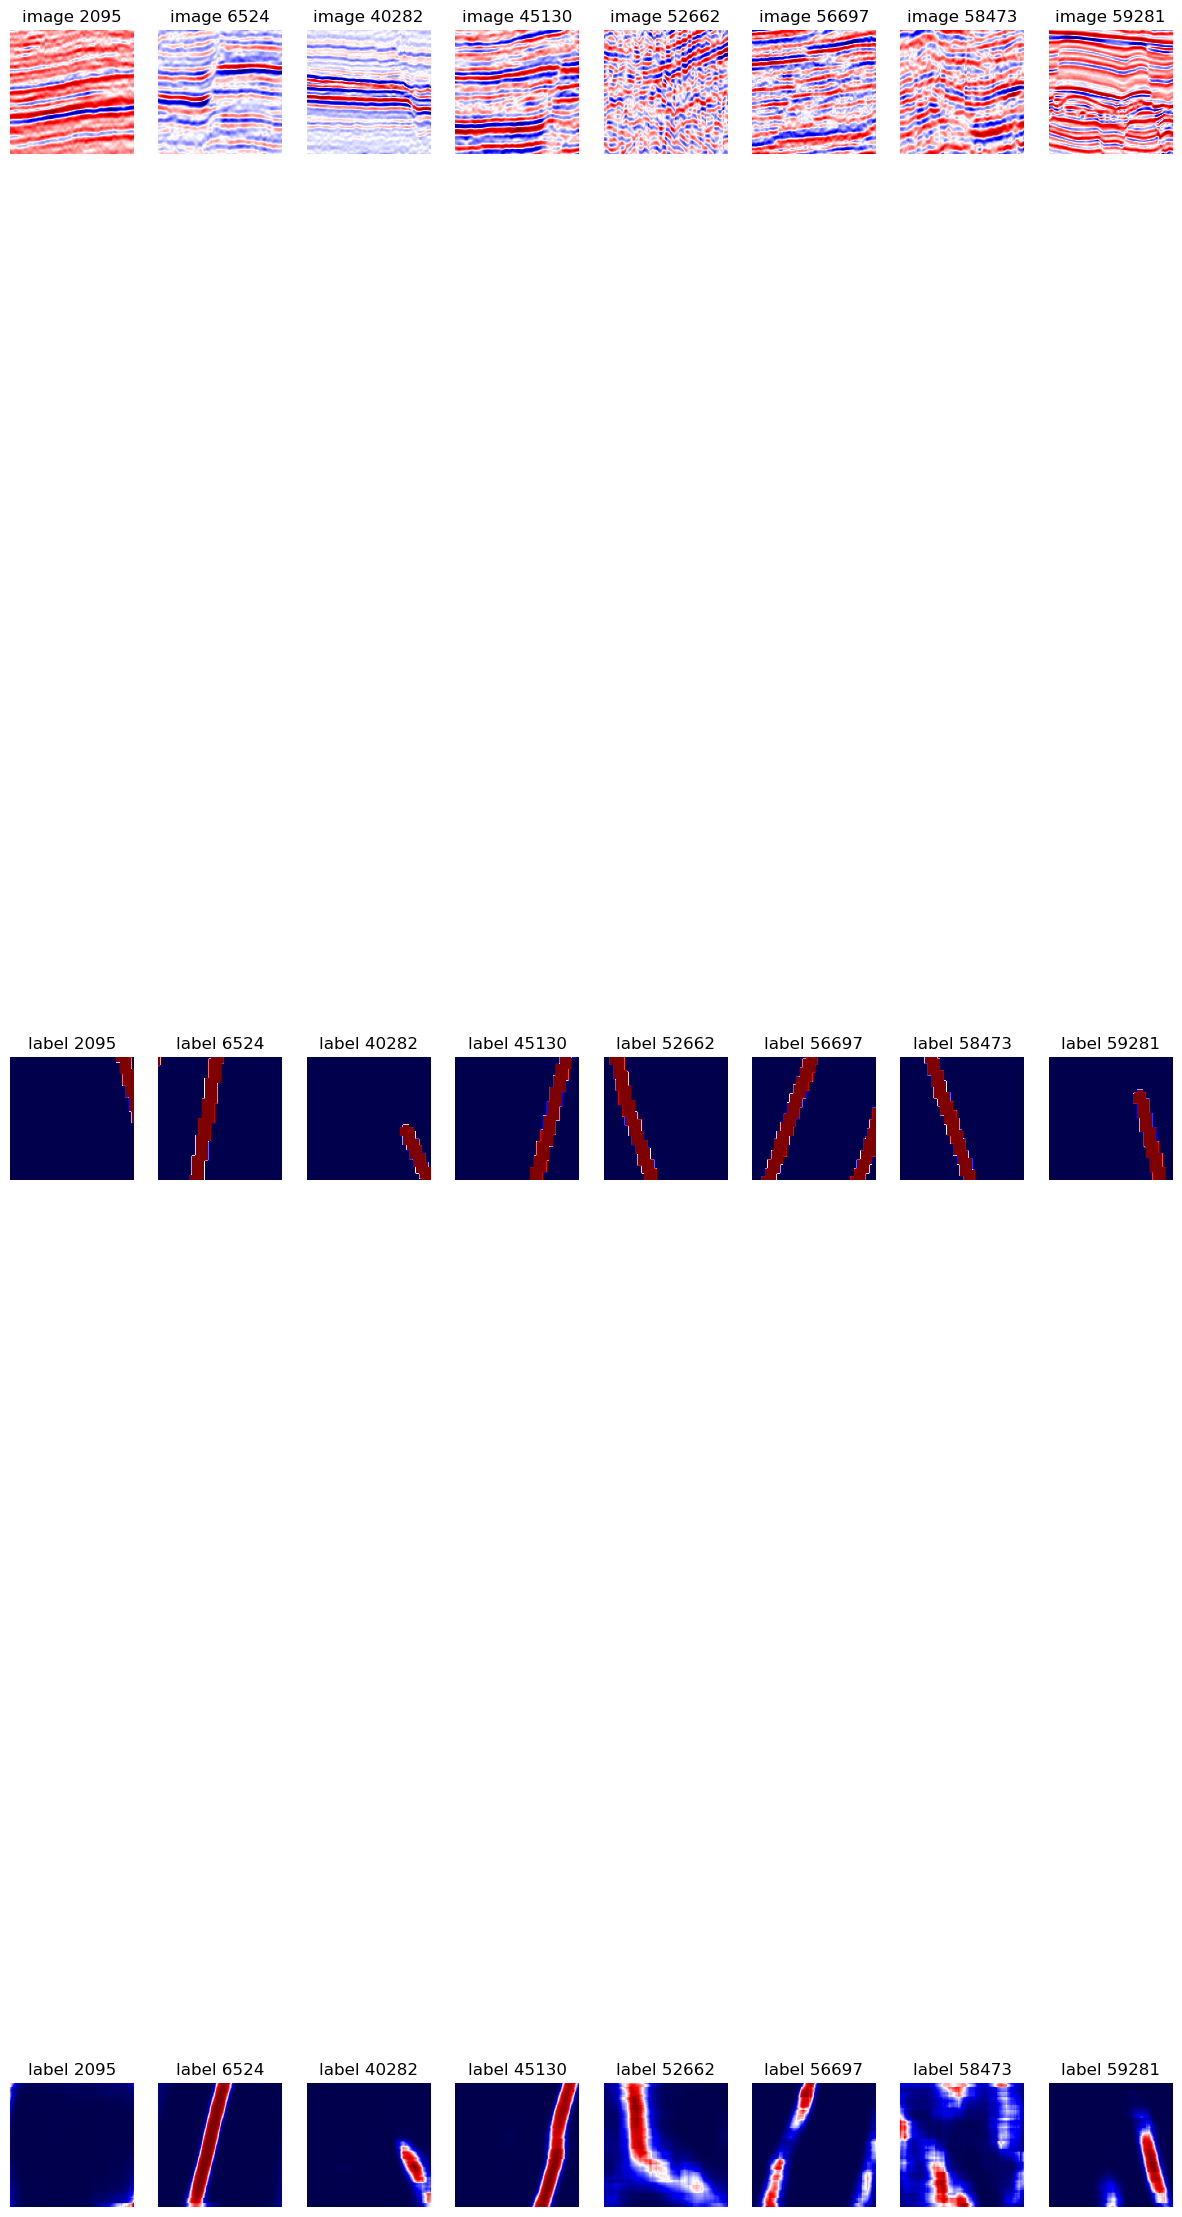

In [15]:

if INTERACTIVE_SESSION:
    seis.display_sample_images(x_test, y_test, y_pred)
    

In [16]:
model.evaluate(x=x_test)


   1/2065 [..............................] - ETA: 11:09 - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

  47/2065 [..............................] - ETA: 2s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan   

  94/2065 [>.............................] - ETA: 2s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 142/2065 [=>............................] - ETA: 2s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 190/2065 [=>............................] - ETA: 2s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 238/2065 [==>...........................] - ETA: 1s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 286/2065 [===>..........................] - ETA: 1s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 333/2065 [===>..........................] - ETA: 1s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 381/2065 [====>.........................] - ETA: 1s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 429/2065 [=====>........................] - ETA: 1s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 476/2065 [=====>........................] - ETA: 1s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 522/2065 [======>.......................] - ETA: 1s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 570/2065 [=======>......................] - ETA: 1s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 619/2065 [=======>......................] - ETA: 1s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 668/2065 [========>.....................] - ETA: 1s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 716/2065 [=========>....................] - ETA: 1s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 764/2065 [==========>...................] - ETA: 1s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 812/2065 [==========>...................] - ETA: 1s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 861/2065 [===========>..................] - ETA: 1s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 907/2065 [============>.................] - ETA: 1s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

 955/2065 [============>.................] - ETA: 1s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1003/2065 [=============>................] - ETA: 1s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1051/2065 [==============>...............] - ETA: 1s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1099/2065 [==============>...............] - ETA: 1s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1147/2065 [===============>..............] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1196/2065 [================>.............] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1244/2065 [=================>............] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1291/2065 [=================>............] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1340/2065 [==================>...........] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1388/2065 [===================>..........] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1436/2065 [===================>..........] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1484/2065 [====================>.........] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1532/2065 [=====================>........] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1580/2065 [=====================>........] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1629/2065 [======================>.......] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1677/2065 [=======================>......] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1724/2065 [========================>.....] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1773/2065 [========================>.....] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1821/2065 [=========================>....] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1870/2065 [==========================>...] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1918/2065 [==========================>...] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

1966/2065 [===========================>..] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

2014/2065 [============================>.] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

2062/2065 [============================>.] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan

2065/2065 [==============================] - 3s 1ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: nan


[0.0, 0.0, nan]

In [17]:

scores = conf.evaluate_sklearn(y_test, y_pred,report=True)
print(scores)

evaluation elapsed time:___24.18___minutes
                      0            1  accuracy     macro avg  weighted avg
precision  9.900000e-01         0.20      0.59  5.900000e-01  9.000000e-01
recall     5.500000e-01         0.94      0.59  7.400000e-01  5.900000e-01
f1-score   7.100000e-01         0.33      0.59  5.200000e-01  6.700000e-01
support    5.443481e+08  64617490.00      0.59  6.089656e+08  6.089656e+08
{'Avg-precision': 0.58, 'f1-score(ODS)': 0.33}
